In [208]:
# Package imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math
import pdb
import pickle
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import os
import time
#### Interesting Results with conf:
# batch_size = 50
# num_epochs = 100
# n_folds = 1
# lr = 0.01
# featx = 96
# def mlp(input_,input_dim,output_dim,name="mlp"):
#     with tf.variable_scope(name):
#         w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.random_normal_initializer(mean = 0.0001,stddev=0.001))
#         #w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.contrib.layers.xavier_initializer())
#         return tf.nn.tanh(tf.matmul(input_,w))
# node_sizes = {'input':featx,'l1':50,'l2':50,'output':2,'kernel_dim':5,'max_pool_redux_factor':16}

In [362]:
# Model Architecture Defs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#MLP
def build_model(X_,_dropout,node_sizes,net_type,phase):
    if net_type == 'mlpnet':
        model = mlpnet(X_,_dropout,node_sizes,phase)
    elif net_type == 'convnet':
        model = convnet(X_,_dropout,node_sizes)
    else: 
        print('unknown net architecture type')
    return model

def mlpnet(image,_dropout,node_sizes,phase):
    l1 = mlp(image,node_sizes['input'],node_sizes['l1'],name='l1')
    #batch normalization
    #l1 = tf.contrib.layers.batch_norm(l1, center=True, scale=True, is_training=phase,scope='bn1')
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = mlp(l1,node_sizes['l1'],node_sizes['l2'],name='l2')
    #batch normalization
    #l2 = tf.contrib.layers.batch_norm(l2, center=True, scale=True, is_training=phase,scope='bn2')    
    l2 = tf.nn.dropout(l2,_dropout)
    
#     l3 = mlp(l2,node_sizes['l2'],node_sizes['l3'],name='l3')
#     l3 = tf.nn.dropout(l3,1)
    l4 = mlp(l2,node_sizes['l2'],node_sizes['output'],name='l4')
    return l4

def mlp(input_,input_dim,output_dim,name="mlp"):
    with tf.variable_scope(name):
        #w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.random_normal_initializer(mean = 0.001,stddev=0.02))
        w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.contrib.layers.xavier_initializer())
        return tf.nn.relu(tf.matmul(input_,w))
        #return tf.nn.tanh(tf.matmul(input_,w))

#Convnet
def convnet(X_,_dropout,node_sizes):
    image_dim = int(np.sqrt(node_sizes['input']))
    final_image_vector_size = node_sizes['input']/node_sizes['max_pool_redux_factor']
    
    X_image = tf.reshape(X_, [-1,image_dim,image_dim,1])
    l1 = conv(X_image,node_sizes['kernel_dim'], 1, node_sizes['l1'], name='l1')  
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = conv(l1,node_sizes['kernel_dim'], node_sizes['l1'], node_sizes['l2'], name='l2')
    l2 = tf.nn.dropout(l2,_dropout)
    
    #reshape to vector (reduced image size*number of filters)
    l2_flat = tf.reshape(l2, [-1, final_image_vector_size*node_sizes['l2']])    
    l3 = mlp(l2_flat,final_image_vector_size*node_sizes['l2'],node_sizes['output'],name='mlp')    
    #l3 = tf.nn.dropout(l3,_dropout) #Doesnt work well
    return l3
    
def conv(input_, kernel_dim, in_channels, output_dim,name="conv"):
    with tf.variable_scope(name):
        W = tf.get_variable('w',[kernel_dim, kernel_dim, in_channels, output_dim],
                            tf.float32,tf.random_normal_initializer(mean = 0.01,stddev=0.02))
        b = tf.get_variable('b',[output_dim],tf.float32,tf.constant_initializer(0.1))                        
        h_conv = tf.nn.relu(conv2d(input_, W) + b)
        h_pool = max_pool_2x2(h_conv)
        return h_pool
    
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
# def weight_variable(shape):
#     initial = tf.truncated_normal(shape, stddev=0.1)
#     return tf.Variable(initial)

# def bias_variable(shape):
#     initial = tf.constant(0.1, shape=shape)
#     return tf.Variable(initial)

# Loss and accuracy
def contrastive_loss(y,d,score_mod,use_mod):
    use_mod = False
    if use_mod:
        tmp= y *tf.square(d*score_mod)
        #tmp= tf.mul(y,tf.square(d))
        tmp2 = (1-y) *tf.square(tf.maximum((1 - d*score_mod),0))
    else:
        tmp= y *tf.square(d)
        #tmp= tf.mul(y,tf.square(d))
        tmp2 = (1-y) *tf.square(tf.maximum((1 - d),0))
        
        loss = tf.reduce_sum(tmp +tmp2)/batch_size/2                
    return loss

def compute_accuracy(prediction,labels):
    return labels[prediction.ravel() < 0.5].mean()
    #return tf.reduce_mean(labels[prediction.ravel() < 0.5])
    
def next_batch(s,e,inputs,labels,score_diff):
    input1 = inputs[s:e,0]
    input2 = inputs[s:e,1]        
    y = np.reshape(labels[s:e],(len(range(s,e)),1))
    score_mod = np.reshape(score_diff[s:e],(len(range(s,e)),1))
    return input1,input2,y,score_mod

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    left_digits = []
    right_digits = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]            
            left_digits.append(d)
            right_digits.append(d)            
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            left_digits.append(d)
            right_digits.append(dn)
    return np.array(pairs), np.array(labels), np.array(left_digits), np.array(right_digits)


def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f,protocol=2)
    f.close()

In [363]:
# Load data

# Load Data

baseline_dir = '/projects/nbhagwat/Traj_prediction/ADNI/exp_setup/'

exp_name = 'Exp_102_ADNI2_traj_MMSE_tp_var_tp'
use_ct = True
var_tp = True
shuffle_labels = False # What's your performance with random labels. 
scale_data = False

exp_setup_path = baseline_dir + 'KFolds/' + exp_name + '_sKF.pkl'

with open(exp_setup_path, 'rb') as f:
    exp_setup = pickle.load(f, encoding='latin') 


#Check if loading the correct experimental setup
if exp_name != exp_setup['exp_name']:
    print('Incorrect exp_name. Selected:{}, Retrieved:{}'.format(exp_name, exp_setup['exp_name']))

else:
    print('exp_name: {}'.format(exp_name))
    
    df = exp_setup['df']
    kf = exp_setup['sKF']
    
    feat_cols = []    
        
    if var_tp:
        ct_cols_bl = list(df.columns[pd.Series(df.columns).str.contains('CT_bl')])
        ct_cols_tp_rate = list(df.columns[pd.Series(df.columns).str.contains('CT_var_tp')])
        ct_cols = ct_cols_bl + ct_cols_tp_rate
    else:
        ct_cols = list(df.columns[pd.Series(df.columns).str.contains('CT')])

    feat_cols = ct_cols

    X_raw = np.array(df[feat_cols]) #Otherwise scaling and shifting will remain the same for next model. 
    y = np.array(df['traj']) 
    
    #Flip labels (sanity check to see of contrastive loss is dependent on the label values)
    y = np.square(y-1)
    
    print('X,y shapes:{},{}'.format(X_raw.shape,y.shape))
    
    # Create list of all the fold-subsets (needed for parallelization)
    Sub_train_kf =[]
    Sub_test_kf = []
    X_train_kf = []
    X_test_kf = []
    y_train_kf = []
    y_test_kf = []    

    start_time = time.time()
    for train, test in kf:
        Sub_train_kf.append(df['PTID'].values[train]) 
        Sub_test_kf.append(df['PTID'].values[test]) 
        X_tr = X_raw[train]
        y_tr = y[train]
        X_te = X_raw[test]
        y_te = y[test]

        if scale_data:
            scaler = preprocessing.StandardScaler().fit(X_tr)
            X_tr = scaler.transform(X_tr)
            X_te = scaler.transform(X_te)
            
            
        X_train_kf.append(X_tr)
        y_train_kf.append(y_tr)

        # No need to resample test data
        X_test_kf.append(X_te)            
        y_test_kf.append(y_te)

exp_name: Exp_102_ADNI2_traj_MMSE_tp_var_tp
X,y shapes:(566, 156),(566,)


In [364]:
#Need to change loss function 
print(y[:10])
print(np.square(y-1)[:10])


[0 1 1 1 1 1 1 0 1 1]
[1 0 0 0 0 0 0 1 0 0]


In [ ]:
# Run models
batch_size = 100
num_epochs = 1000
n_folds = 10
lr = 0.0002
keep_p = 1
tp_offset = 78
use_mod = False
model_choice = 'Siamese_Layer2'
save_perf = True

#Track performance for each fold
kf_train_acc = []
kf_valid_acc = []
kf_test_acc = []
df_perf_concat = pd.DataFrame()
#global_step = tf.Variable(0,trainable=False)
#starter_learning_rate = 0.0001
#learning_rate = tf.train.exponential_decay(starter_learning_rate,global_step,10,0.1,staircase=True)

start_time = time.time()
for fid in range(n_folds):    
    print('Foldx:{}'.format(fid+1))
    df_perf = pd.DataFrame()
    
    #list keeping track of each batch perf
    train_loss = []
    train_acc = []
    valid_acc = []
    test_acc = []
   
    X_L = X_train_kf[fid][:,:tp_offset]
    X_R = X_train_kf[fid][:,tp_offset:]
    
    pairs = np.concatenate((X_L[:,np.newaxis,:],X_R[:,np.newaxis,:]),axis=1)
    y = y_train_kf[fid]
    
    #Create train-validation sets
    tr_split = int(0.9*len(y))
    tr_pairs = pairs[:tr_split,:,:]
    va_pairs = pairs[tr_split:,:,:]
    tr_y = y[:tr_split]
    va_y = y[tr_split:]
    
        
    print(pairs.shape, tr_split, len(y))

    X_L = X_test_kf[fid][:,:tp_offset]
    X_R = X_test_kf[fid][:,tp_offset:]
    
    te_pairs = np.concatenate((X_L[:,np.newaxis,:],X_R[:,np.newaxis,:]),axis=1)
    te_y = y_test_kf[fid]
    
    score_diff = tr_pairs[:,0,-1] - tr_pairs[:,1,-1]
    print(tr_pairs.shape,va_pairs.shape,te_pairs.shape,tr_y.shape,va_y.shape,te_y.shape)

    # Define input and model tensors + optimizer 
    
    node_sizes = {'input':tp_offset,'l1':50,'l2':10,'l3':0,'output':10,'kernel_dim':5,'max_pool_redux_factor':16}
    with tf.Graph().as_default():    
        images_L = tf.placeholder(tf.float32,shape=([None,node_sizes['input']]),name='L')
        images_R = tf.placeholder(tf.float32,shape=([None,node_sizes['input']]),name='R')
        labels = tf.placeholder(tf.float32,shape=([None,1]),name='gt')
        modulator = tf.placeholder(tf.float32,shape=([None,1]),name='md')
        
        dropout_f = tf.placeholder("float")
        phase = tf.placeholder("bool") #for batch normalization

        with tf.variable_scope("siamese") as scope:
            model1= build_model(images_L,dropout_f,node_sizes,'mlpnet',phase)
            scope.reuse_variables()
            model2 = build_model(images_R,dropout_f,node_sizes,'mlpnet',phase)

        distance  = tf.exp(-1*(tf.reduce_sum(tf.pow(tf.sub(model1,model2),2),1,keep_dims=True)))
        #distance  = tf.exp(-1*tf.sqrt(tf.reduce_sum(tf.pow(tf.sub(model1,model2),2),1,keep_dims=True)))
        #distance  = tf.sigmoid(tf.sqrt(tf.reduce_sum(tf.pow(tf.sub(model1,model2),2),1,keep_dims=True)))
        loss = contrastive_loss(labels,distance,modulator,use_mod)

        #contrastice loss
        t_vars = tf.trainable_variables()
        d_vars  = [var for var in t_vars if 'l' in var.name]
        batch = tf.Variable(0)
        optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)
        #optimizer = tf.train.RMSPropOptimizer(0.0001,momentum=0.9,epsilon=1e-6).minimize(loss)

        # Launch the graph
        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
            #sess.run(init)
            tf.initialize_all_variables().run()
            # Training cycle
            for epoch in range(num_epochs):
                avg_loss = 0.
                avg_acc = 0.
                total_batch = int(tr_pairs.shape[0]/batch_size)
                start_time = time.time()
                # Loop over all batches
                for i in range(total_batch):
                    s  = i * batch_size
                    e = (i+1) *batch_size
                    
                    # Fit training using batch data
                    input1,input2,y,score_mod = next_batch(s,e,tr_pairs,tr_y, score_diff)           
                                
                    _,loss_value,predict=sess.run([optimizer,loss,distance], 
                                                  feed_dict={images_L:input1,images_R:input2,labels:y, 
                                                             modulator:score_mod,dropout_f:keep_p,phase:True})

                    feature1=model1.eval(feed_dict={images_L:input1,dropout_f:keep_p,phase:False})
                    feature2=model2.eval(feed_dict={images_R:input2,dropout_f:keep_p,phase:False})

                    tr_acc = compute_accuracy(predict,y)
                    #print(tr_acc)
#                     if math.isnan(tr_acc) and epoch != 0:
#                         print('tr_acc %0.2f' % tr_acc)
#                         pdb.set_trace()

                    avg_loss += loss_value
                    avg_acc +=tr_acc*100
                                                                
                
                #print('epoch %d loss %0.2f' %(epoch,avg_loss/total_batch))
                duration = time.time() - start_time
                #print('epoch %d  time: %f loss %0.5f acc %0.2f' %(epoch,duration,avg_loss/(total_batch),avg_acc/total_batch))
                train_loss.append(avg_loss/(total_batch))
                train_acc.append(avg_acc/total_batch)
                
                
                
                #Check performance on validation set                                                                
                valid_feature_1 = model1.eval(feed_dict={images_L:va_pairs[:,0],dropout_f:1,phase:False})
                valid_feature_2 = model2.eval(feed_dict={images_R:va_pairs[:,1],dropout_f:1,phase:False})                
                y = np.reshape(va_y,(va_y.shape[0],1))
                predict=distance.eval(feed_dict={images_L:va_pairs[:,0],images_R:va_pairs[:,1],labels:y,
                                                 dropout_f:1.0,phase:False})                
                va_acc = compute_accuracy(predict,y)*100 
                valid_acc.append(va_acc)
                #print('Accuracy validation set %0.2f' % (va_acc))         
                
                
                
                if epoch%10 == 0:
                    print('Epoch:{}, Accuracy train:{:4.3f},valid:{:4.3f}'.format(epoch,avg_acc/total_batch,va_acc))
                    print('distance:{:4.3f}, loss:{:4.3f}'.format(np.mean(predict),avg_loss/(total_batch)))
                    
            #Accuracy of the entire training set at the end of training
            y = np.reshape(tr_y,(tr_y.shape[0],1))
            predict=distance.eval(feed_dict={images_L:tr_pairs[:,0],images_R:tr_pairs[:,1],labels:y,
                                             dropout_f:1.0,phase:False})
            tr_acc = compute_accuracy(predict,y)
            print('Accuracy training set %0.2f' % (100 * tr_acc))
            print('Accuracy validation set %0.2f' % (va_acc))


            # Test model
            train_feature_1 = model1.eval(feed_dict={images_L:tr_pairs[:,0],dropout_f:1,phase:False})
            train_feature_2 = model2.eval(feed_dict={images_R:tr_pairs[:,1],dropout_f:1,phase:False})
            test_feature_1 = model1.eval(feed_dict={images_L:te_pairs[:,0],dropout_f:1,phase:False})
            test_feature_2 = model2.eval(feed_dict={images_R:te_pairs[:,1],dropout_f:1,phase:False})
            
            y = np.reshape(te_y,(te_y.shape[0],1))
            predict=distance.eval(feed_dict={images_L:te_pairs[:,0],images_R:te_pairs[:,1],labels:y,
                                             dropout_f:1.0,phase:False})            
            te_acc = compute_accuracy(predict,y)
            test_acc.append(te_acc)
            print('Accuracy test set %0.2f' % (100 * te_acc))
            
            #Save perf method 1: df of all subjects
            df_perf['PTID'] = Sub_test_kf[fid]
            df_perf['model'] = np.tile(model_choice,len(te_y))
            df_perf['kf'] = np.tile(fid+1,len(te_y))
            df_perf['act_label'] = te_y
            df_perf['pred_label'] = (predict.ravel() < 0.5).astype(int)
            a = np.squeeze(np.minimum(predict,np.ones((len(predict),1))))
            b = np.squeeze(1-a)
            y_pred_prob = np.vstack((a,b)).T
            df_perf['pred_prob'] = list(y_pred_prob)            
            df_perf['test_embed_L'] = list(test_feature_1)
            df_perf['test_embed_R'] = list(test_feature_2)
            
            df_perf_concat = df_perf_concat.append(df_perf)
            
        kf_train_acc.append(tr_acc)
        kf_valid_acc.append(va_acc)
        kf_test_acc.append(te_acc)
                                   
            
#Save perf df
if save_perf:
    pickleIt(df_perf_concat, '{}TF_perf/{}_{}_df_perf.pkl'.format(baseline_dir,exp_name,model_choice)) 
    
print('total_time:: {}'.format((time.time() - start_time)/60.0))
        

Foldx:1
(509, 2, 78) 458 509
(458, 2, 78) (51, 2, 78) (57, 2, 78) (458,) (51,) (57,)
Epoch:0, Accuracy train:54.417,valid:63.158
distance:0.546, loss:0.156
Epoch:10, Accuracy train:66.626,valid:76.923
distance:0.396, loss:0.110
Epoch:20, Accuracy train:68.159,valid:77.500
distance:0.399, loss:0.105
Epoch:30, Accuracy train:69.579,valid:77.500
distance:0.401, loss:0.102
Epoch:40, Accuracy train:70.474,valid:77.500
distance:0.402, loss:0.099
Epoch:50, Accuracy train:72.207,valid:77.500
distance:0.401, loss:0.096
Epoch:60, Accuracy train:73.145,valid:76.923
distance:0.405, loss:0.093
Epoch:70, Accuracy train:73.804,valid:76.923
distance:0.400, loss:0.090
Epoch:80, Accuracy train:74.499,valid:76.316
distance:0.402, loss:0.088
Epoch:90, Accuracy train:74.936,valid:76.316
distance:0.404, loss:0.086
Epoch:100, Accuracy train:76.147,valid:78.378
distance:0.406, loss:0.085
Epoch:110, Accuracy train:76.705,valid:78.378
distance:0.408, loss:0.083
Epoch:120, Accuracy train:77.333,valid:78.378
dist

In [389]:
#K-fold stats
print(kf_train_acc)
print(kf_valid_acc)
print(kf_test_acc)
print(np.mean(kf_train_acc),np.mean(kf_valid_acc),np.mean(kf_test_acc))


# Prediction Probs for Siamese net
# a = np.squeeze(np.minimum(predict,np.ones((len(predict),1))))
# b = np.squeeze(1-a)
# print(a[:10])
# print(b[:10])
# np.vstack((a,b)).T[:10]
# plt.hist(predict)
#pickleIt(df_perf_concat, '{}TF_perf/{}_{}_df_perf.pkl'.format(baseline_dir,exp_name,model_choice))

#X_train_kf[fid]

[0.87138263665594851, 0.85530546623794212, 0.85855263157894735, 0.86084142394822005, 0.83281733746130027, 0.82636655948553051, 0.85256410256410253, 0.82445141065830718, 0.80615384615384611, 0.82594936708860756]
[91.17647058823529, 84.848484848484844, 83.870967741935488, 86.666666666666671, 88.571428571428569, 86.111111111111114, 88.888888888888886, 86.666666666666671, 77.5, 85.294117647058826]
[0.77777777777777779, 0.71052631578947367, 0.67391304347826086, 0.77777777777777779, 0.73170731707317072, 0.82926829268292679, 0.76923076923076927, 0.80000000000000004, 0.81578947368421051, 0.82857142857142863]
0.841438478183 85.959480273 0.771456219607


0.828571428571
[0.82857142857142863]


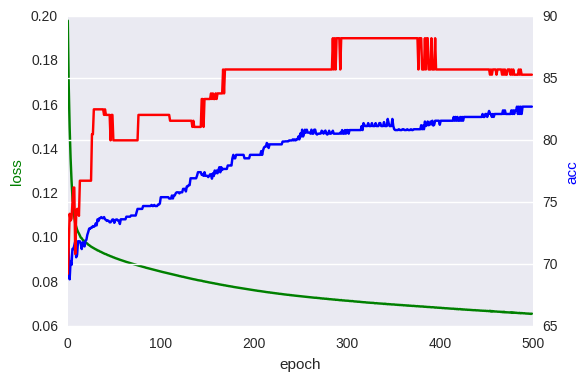

In [390]:
# Plot Acc and Loss
print(np.mean(np.array(test_acc)))
print(test_acc)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(train_loss, 'g-')
ax2.plot(train_acc, 'b-')
ax2.plot(valid_acc, 'r-')


ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color='g')
ax2.set_ylabel('acc', color='b')
ax1.grid()


In [386]:
#TSNE
from sklearn.manifold import TSNE
tsne_df = pd.DataFrame()

tsne_df_train = pd.DataFrame()
tsne_df_train['PTID'] = Sub_train_kf[fid][:tr_split]
tsne_df_train['labels'] = tr_y
tsne_df_train['subset'] = np.tile('train',len(tr_y))
tsne_df_train['KF'] = np.tile(fid,len(tr_y))

tsne_df_test = pd.DataFrame()
tsne_df_test['PTID'] = Sub_test_kf[fid]
tsne_df_test['labels'] = te_y
tsne_df_test['subset'] = np.tile('test',len(te_y))
tsne_df_test['KF'] = np.tile(fid,len(te_y))

tsne_train_layers = {'l1':train_feature_1,'l2':train_feature_2}
tsne_test_layers = {'l1':test_feature_1,'l2':test_feature_2}

for l in tsne_train_layers:
    tsne = TSNE(n_components=2, random_state=0,init='pca')
    tsne_embed = tsne.fit_transform(tsne_train_layers[l])
    tsne_df_train['TSNE_{}_x'.format(l)] = tsne_embed[:,0]
    tsne_df_train['TSNE_{}_y'.format(l)] = tsne_embed[:,1]

for l in tsne_test_layers:
    tsne = TSNE(n_components=2, random_state=0,init='pca')
    tsne_embed = tsne.fit_transform(tsne_test_layers[l])
    tsne_df_test['TSNE_{}_x'.format(l)] = tsne_embed[:,0]
    tsne_df_test['TSNE_{}_y'.format(l)] = tsne_embed[:,1]

tsne_df = tsne_df_train.append(tsne_df_test)

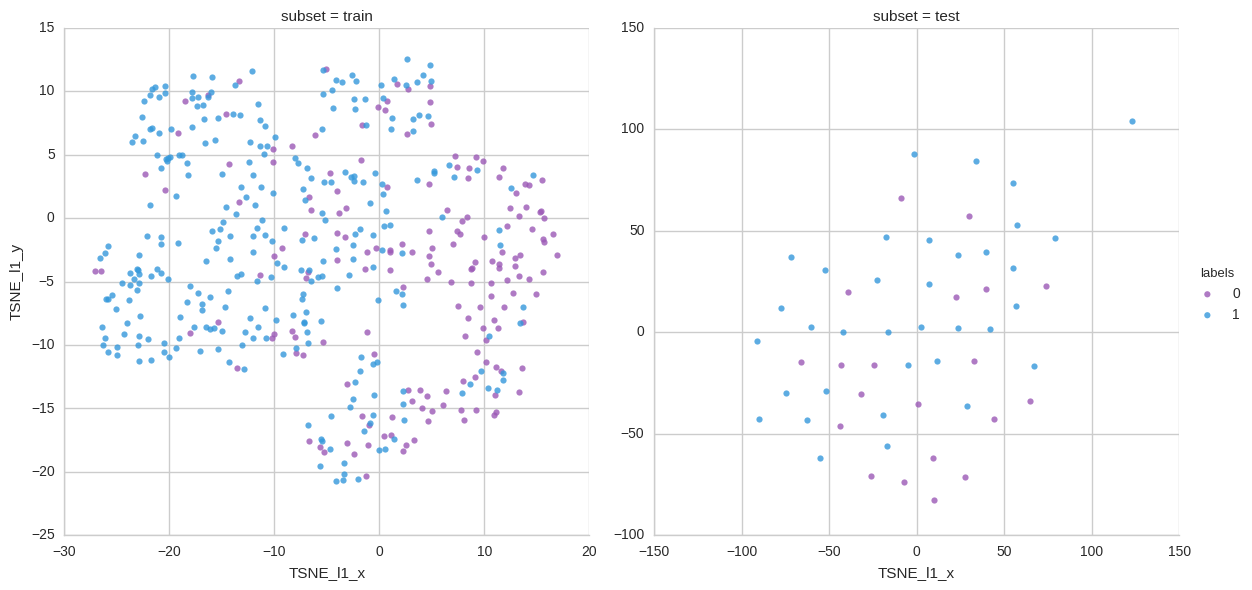

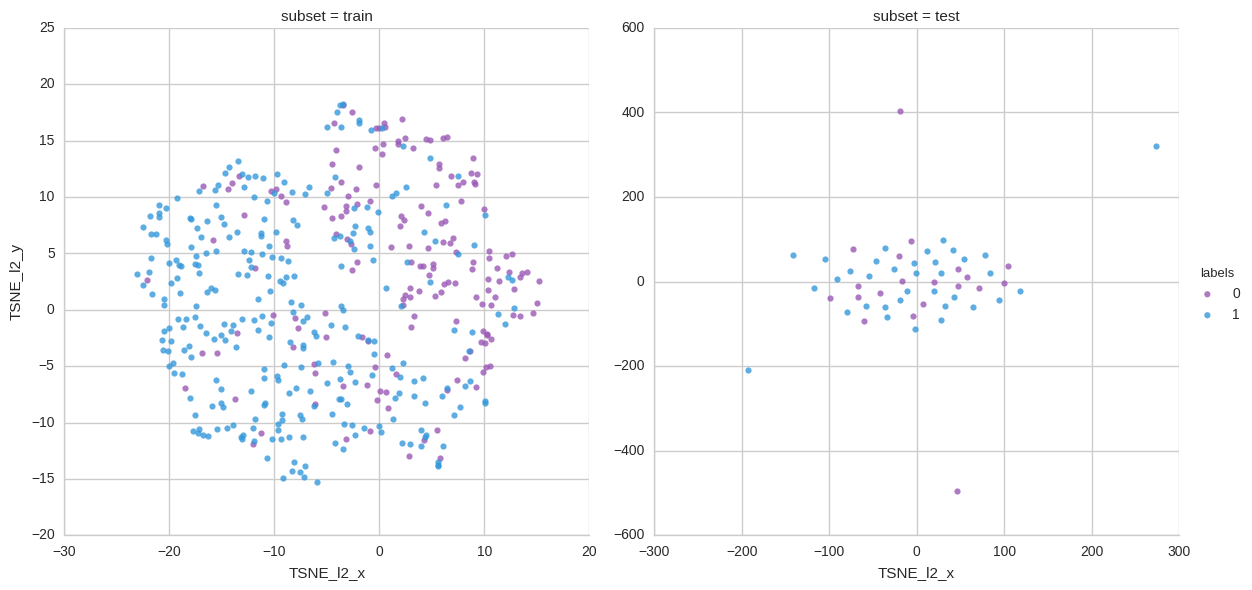

In [387]:
flatui = ["#9b59b6", "#3498db", "#e74c3c", "#34495e", "#2ecc71", "#95a5a6"]

with sns.axes_style("whitegrid"):
    g1 = sns.lmplot('TSNE_l1_x','TSNE_l1_y',fit_reg=False,hue='labels',col='subset',data=tsne_df,
                    markers='o',size=6,sharey=False,sharex=False,palette=flatui)
    g1 = sns.lmplot('TSNE_l2_x','TSNE_l2_y',fit_reg=False,hue='labels',col='subset',data=tsne_df,
                    markers='o',size=6,sharey=False,sharex=False,palette=flatui) 

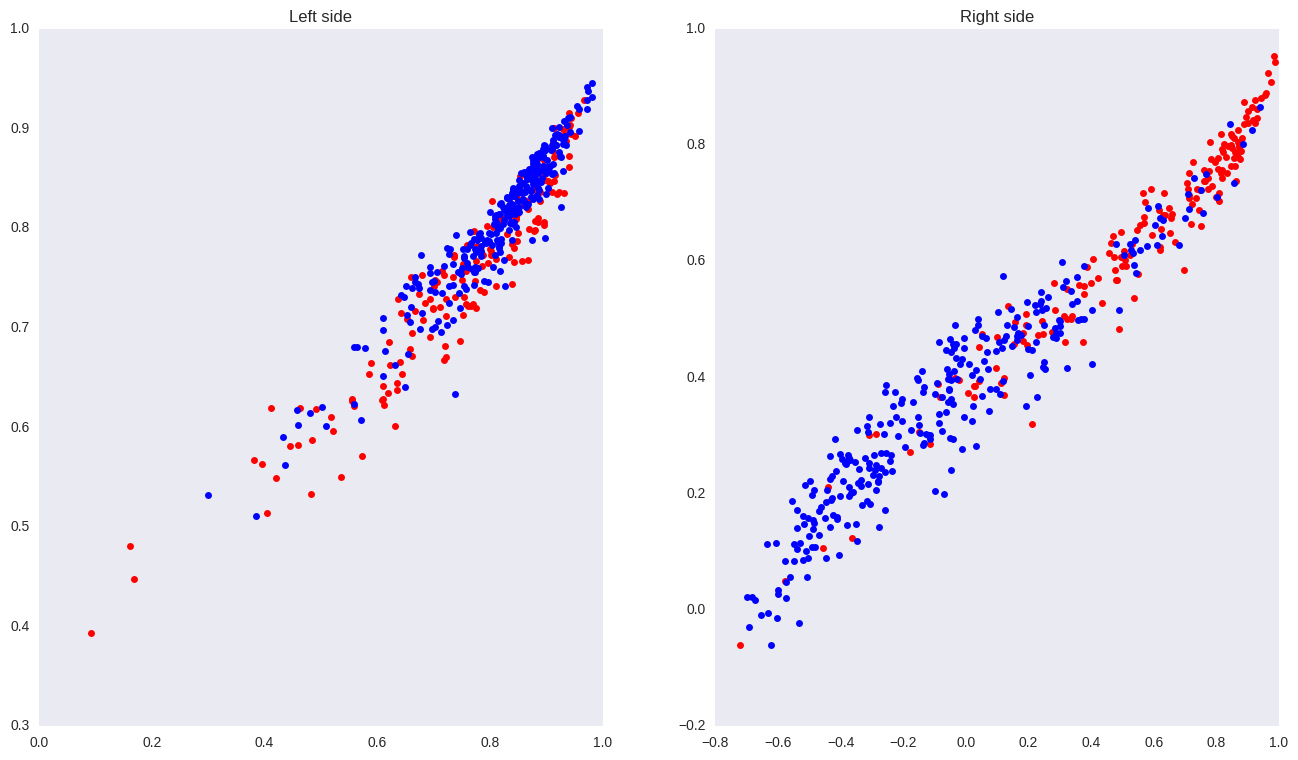

In [324]:
#Plot embeddings
f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#0000ff', '#ffff00', '#00ff00', '#009999',
     '#ff00ff', '#00ffff', '#990000', '#999900', '#009900' ]
mark_size= 10

plt.subplot(1,2,1)
x = train_feature_1[:,0] 
y = train_feature_1[:,1] 
labels = tr_y #left_digits
for i in range(2):
    plt.plot(x[labels==i],y[labels==i],'.', c=c[i], markersize=mark_size)
    
# x = test_feature_1[:,0] 
# y = test_feature_1[:,1] 
# labels = te_y #left_digits
# for i in range(2):
#     plt.plot(x[labels==i],y[labels==i],'d', c=c[i+5], markersize=mark_size)

    
#plt.legend(['train_class_1', 'train_class_2', 'test_class_1', 'test_class_2'],loc=1)
plt.grid()
plt.title('Left side')

plt.subplot(1,2,2)
x = train_feature_2[:,0] 
y = train_feature_2[:,1] 
labels = tr_y #right_digits
for i in range(2):
    plt.plot(x[labels==i],y[labels==i],'.', c=c[i], markersize=mark_size)

# x = test_feature_2[:,0] 
# y = test_feature_2[:,1] 
# labels = te_y #right_digits
# for i in range(2):
#     plt.plot(x[labels==i],y[labels==i],'d', c=c[i+5], markersize=mark_size)

# #plt.legend(['train_class_1', 'train_class_2', 'test_class_1', 'test_class_2'], loc=1)
plt.grid()
plt.title('Right side')

In [393]:
print np.sum(tr_y==0),np.sum(tr_y==1)
print np.sum(te_y==0),np.sum(te_y==1)

373 388
42 48


In [285]:
df_perf_concat

,PTID,model,kf,act_label,pred_label,pred_prob,test_embed_L,test_embed_R
0,002_S_4171,Siamese_Layer2,1,1,0,"[1.0, 0.0]","[-0.898683, 0.972407, 0.995047, 0.996545, 0.98...","[-0.953308, 0.984501, 0.996951, 0.99636, 0.993..."
1,002_S_4213,Siamese_Layer2,1,0,1,"[0.374746263027, 0.625253736973]","[-0.960725, 0.987913, 0.997915, 0.997628, 0.99...","[-0.951188, 0.984422, 0.996685, 0.996543, 0.99..."
2,002_S_4219,Siamese_Layer2,1,0,0,"[0.91649800539, 0.0835019946098]","[-0.962563, 0.988732, 0.996943, 0.996692, 0.99...","[-0.926553, 0.983202, 0.995957, 0.994826, 0.98..."
3,002_S_4225,Siamese_Layer2,1,0,0,"[0.68315577507, 0.31684422493]","[-0.941924, 0.984238, 0.997291, 0.996248, 0.99...","[-0.907436, 0.981647, 0.996571, 0.996445, 0.99..."
4,002_S_4229,Siamese_Layer2,1,0,0,"[0.826193153858, 0.173806846142]","[-0.951204, 0.987512, 0.997919, 0.997261, 0.99...","[-0.913773, 0.984234, 0.997125, 0.996606, 0.98..."
5,002_S_4237,Siamese_Layer2,1,0,0,"[0.572631180286, 0.427368819714]","[-0.970287, 0.991958, 0.998082, 0.997665, 0.99...","[-0.916956, 0.983236, 0.994782, 0.995353, 0.98..."
6,002_S_4251,Siamese_Layer2,1,0,0,"[0.908221781254, 0.0917782187462]","[-0.953558, 0.985684, 0.997313, 0.996856, 0.99...","[-0.907315, 0.98127, 0.996757, 0.996587, 0.991..."
7,002_S_4262,Siamese_Layer2,1,1,1,"[0.0895820334554, 0.910417966545]","[-0.963783, 0.990507, 0.998003, 0.997514, 0.99...","[-0.966966, 0.989528, 0.997148, 0.997474, 0.99..."
8,002_S_4270,Siamese_Layer2,1,0,0,"[0.851790845394, 0.148209154606]","[-0.949769, 0.986972, 0.998005, 0.996699, 0.99...","[-0.906829, 0.981633, 0.997161, 0.996637, 0.99..."
9,002_S_4447,Siamese_Layer2,1,0,0,"[1.0, 0.0]","[-0.954529, 0.986141, 0.995796, 0.994691, 0.99...","[-0.679139, 0.975211, 0.989856, 0.988625, 0.93..."
